# Compare the amplitude with the KdV solution

In [45]:
from soda.dataio import netcdfio
from soda.dataio.conversion import readotps
from soda.utils.othertime import SecondsSince

from datetime import datetime
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import h5py
import seaborn as sns

import matplotlib.dates as mdates

In [2]:
%matplotlib notebook

In [3]:
# Load the KdV solution
dskdv = xr.open_dataset('../output/2019-11-12--00-42-28_slim-harmonic_beta_pred_a0_magnus_kdv_runs.nc')
betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
a0file = '../inputs/a0_samples_harmonicfit_M2S2nonstat_N2K1O1_12month.h5'
sitename = 'harmonic_beta_a0_20162017'

# dskdv = xr.open_dataset('../output/2019-11-27--00-32-41_slim-harmonic_beta_band3_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_bandpass_3h_12month.h5'
# sitename = 'harmonic_beta_a0_bandpass_3h'

# dskdv = xr.open_dataset('../output/2019-11-27--00-34-06_slim-harmonic_beta_band6_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_bandpass_6h_12month.h5'
# sitename = 'harmonic_beta_a0_bandpass_6h'


# Create a time series of single days with the max amplitude 
time1 = pd.date_range('2016-5-1','2016-9-15',freq='12.5H') 
time2 = pd.date_range('2016-11-1','2017-5-1',freq='12.5H')
timemax = time1.append(time2)

dskdv = dskdv.sel(time=range(0,367))



In [63]:
badidx = dskdv.amax==-999.
dskdv.amax.values[badidx] = np.nan
dskdv.ubed.values[badidx] = np.nan
dskdv.a0.values[badidx] = np.nan
dskdv.cn_mu.values[badidx] = np.nan
dskdv.alpha_mu.values[badidx] = np.nan
dskdv.cn.values[badidx] = np.nan
dskdv.alpha.values[badidx] = np.nan

# dskdv.where(dskdv.amax!=-999)

In [5]:
# Get the time from the input beta file

timedays = dskdv.time
nt = timedays.shape[0]

# Get the time from the beta file
with h5py.File(betafile,'r') as f:
    t=f['data/time'][:].astype('<M8[ns]')
time = t[:nt] +  np.timedelta64(1,'D')


time.shape, t.shape, nt

((367,), (367,), 367)

In [6]:
# Load the a0 data
with h5py.File(a0file,'r') as f:
    print([ff for ff in f['data'].keys()])
    ta0=f['data/dtime64'][:].astype('<M8[ns]')
    a0_samples = f['data/a0-all-times-samples'][:]

time[0], ta0[0], a0_samples.shape

['a0-all-times-samples', 'dtime64', 'time']


(numpy.datetime64('2016-05-02T00:00:00.000000000'),
 numpy.datetime64('2016-05-01T00:00:00.000000000'),
 (367, 500))

In [7]:
# update the time
dskdv['time'] = time
#dskdv['time'] = dskdv['time'].astype('<M8[ns]')
#dskdv['time']
dskdv

<xarray.Dataset>
Dimensions:    (ensemble: 500, params: 6, time: 367)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-02 2016-05-03 ... 2017-05-03
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params     (params) int64 0 1 2 3 4 5
Data variables:
    amax       (ensemble, time) float64 -5.405 -2.544 -9.041 ... -22.43 0.0
    tmax       (ensemble, time) float64 ...
    a0         (ensemble, time) float64 4.647 2.214 7.632 ... 16.39 19.08 0.0
    cn         (ensemble, time) float64 1.264 1.231 1.291 ... 1.221 1.281 0.0
    alpha      (ensemble, time) float64 -0.0009492 0.0004067 ... -0.002719 0.0
    alpha2     (ensemble, time) float64 ...
    cn_mu      (ensemble, time) float64 1.534 1.548 1.633 ... 1.5 1.567 0.0
    alpha_mu   (ensemble, time) float64 -0.006235 -0.004683 ... -0.006828 0.0
    alpha2_mu  (ensemble, time) float64 ...
    beta       (time, ensemble, params) float64 ...
    ubed       (ensemble, time) float64 -0.0794 -0.03726

In [8]:
# Validate the amplitude also...
###########
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan


In [9]:
def min_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    
def maximum_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    amp_max = np.nanmax(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

In [10]:
# Find the A_max over one day blocks


Amax_all = []
Amax_time = []
for t1,t2 in zip(timemax[0:-1],timemax[1::]):
    #t2 = t1 + np.timedelta64(1,'D')
    
    #Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    Amax, tidx = min_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)

    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')

<IPython.core.display.Javascript object>

In [11]:
# plot the number of samples
nans = ~np.isnan(dskdv.amax)
N = np.sum(nans,axis=0)
plt.figure()
plt.plot(time,N)

<IPython.core.display.Javascript object>

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


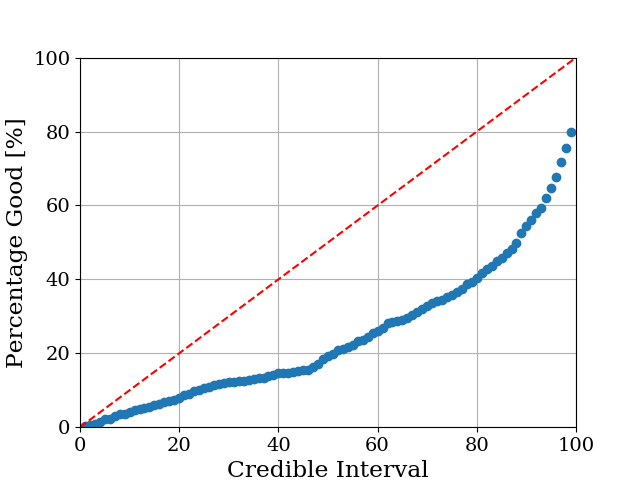

In [27]:
# Count the number of points within each credible interval

# Interplate p95 and p5 onto the observation points

def calc_credint(credint):

    lowval = (100-credint)/2
    highval = 100-(100-credint)/2 

    amax_min = np.nanpercentile(dskdv.amax,lowval, axis=0)
    amax_max = np.nanpercentile(dskdv.amax,highval, axis=0)

    tsec = SecondsSince(time)
    tsec_i = SecondsSince(ds_A['time'].values)

    Fmax = interp1d(tsec, amax_max, bounds_error=False)
    Fmin = interp1d(tsec, amax_min, bounds_error=False)

    amax_min_i = Fmin(tsec_i)
    amax_max_i = Fmax(tsec_i)

    idx_in = (ds_A.values > amax_min_i) & (ds_A.values < amax_max_i)

    nt = tsec_i.shape[0]
    #, lowval, highval
    return np.sum(idx_in)/nt * 100, idx_in

credint = range(1,100)
perc_in = []
for ii in credint:
    pp,_ = calc_credint(ii)
    perc_in.append(pp)
#perc_in = [calc_credint(ii) for ii in credint]

plt.figure()
plt.plot(credint, perc_in,'o')
plt.plot([0,100],[0,100],'r--')
plt.ylim(0,100)
plt.xlim(0,100)
plt.ylabel('Percentage Good [%]')
plt.xlabel('Credible Interval')
plt.grid(b=True)

plt.savefig('../FIGURES/kdv_validation_credint_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_validation_credint_{}.pdf'.format(sitename),dpi=150)

In [28]:
# Count the number of large amplitude wave events within the credible interval
bigwave_thresh = -40
idx = ds_A.values < bigwave_thresh
nlarge = np.sum(idx)

#idx_in = (ds_A.values[idx] > amax_min_i[idx]) & (ds_A.values[idx] < amax_max_i[idx])
pp,idx_in = calc_credint(95)
np.sum(idx_in), nlarge

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


(395, 20)

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


<IPython.core.display.Javascript object>


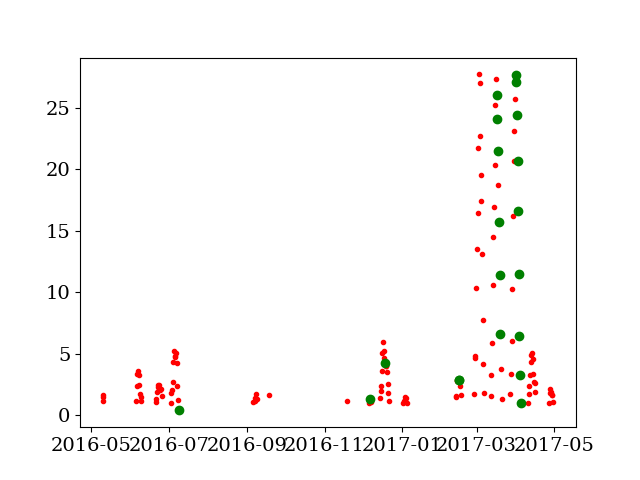

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [29]:
# Calculate the probability
idx_kdv  = dskdv.amax.values < bigwave_thresh
plarge = idx_kdv.sum(axis=0)/500 * 100

tsec = SecondsSince(time)
tsec_i = SecondsSince(ds_A['time'].values)

Fmax = interp1d(tsec, plarge, bounds_error=False)

plarge_i = Fmax(tsec_i)
    
plt.figure()
plt.plot(ds_A['time'].values[plarge_i>1],plarge_i[plarge_i>1],'r.')
plt.plot(ds_A['time'].values[idx],plarge_i[idx],'go')

# Count:
 
 - Number of times obs exceeds the threshold
 - Number of times obs and model exceed 40 m together
 - Number of times model exceeds 40 m but obs. does not
 - Number of times obs. exceeds 40 m but models does not

In [30]:
print('No. obs > thresh = {}'.format(idx.sum()))
print('No. mod > thresh = {}'.format((plarge_i>5).sum()))
print('No. (mod AND obs) > thresh = {}'.format(( (plarge_i>5) & (idx)).sum()))
print('No. mod > thresh but not obs = {}'.format(( (plarge_i>5) & (~idx)).sum()))
print('No. obs > thresh but not mod = {}'.format(idx.sum() - ( (plarge_i>5) & (idx)).sum()))




No. obs > thresh = 20
No. mod > thresh = 44
No. (mod AND obs) > thresh = 13
No. mod > thresh but not obs = 31
No. obs > thresh but not mod = 7


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


<IPython.core.display.Javascript object>


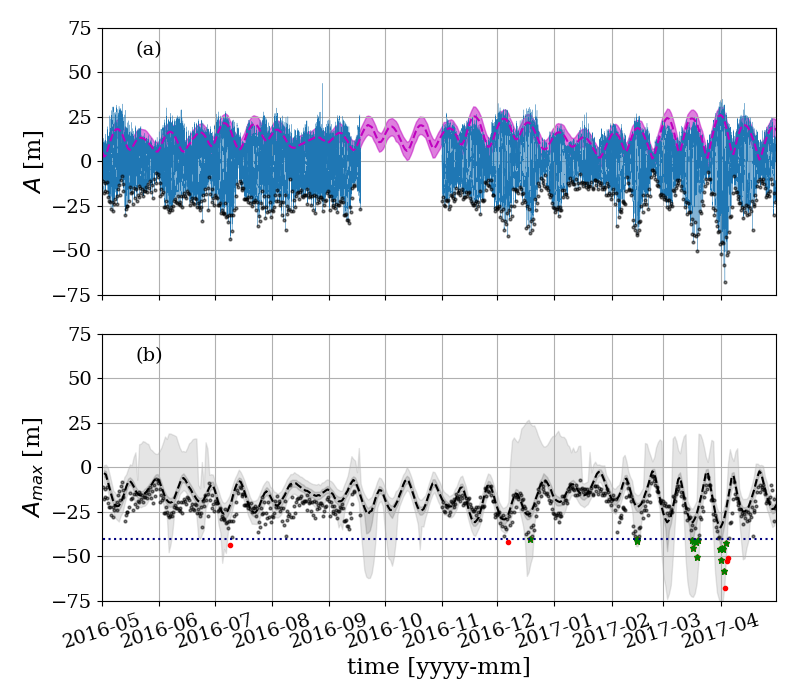

In [34]:
amax_min = np.nanpercentile(dskdv.amax,2.5, axis=0)
amax_max = np.nanpercentile(dskdv.amax,97.5, axis=0)
amax_low = np.nanpercentile(dskdv.amax,25, axis=0)
amax_high = np.nanpercentile(dskdv.amax,75, axis=0)
# amax_amin = np.min(dskdv.amax, axis=0)
# amax_amax = np.max(dskdv.amax, axis=0)
amax_50 = np.nanmedian(dskdv.amax, axis=0)

xlim = [timemax[0],timemax[-1]]
plt.figure(figsize=(8,7))

ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)
plt.plot(ta0, a0_samples.mean(axis=1),'m--')
plt.fill_between(ta0, np.percentile(a0_samples,2.5,axis=1),
         np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

ax1.set_xticklabels([])
plt.xlabel('')
plt.grid(b=True)
plt.ylabel('$A$ [m]')
plt.ylim(-75,75)
plt.title('')
plt.xlim(xlim)
plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)
ax1.set_xticklabels([])

ax2=plt.subplot2grid((4,1),(2,0),rowspan=2,)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
# plt.fill_between(time, amax_min, amax_max, color='0.3',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

plt.plot(ds_A['time'][idx], ds_A.values[idx],'ro', ms=3,)
plt.plot(ds_A['time'][idx_in & idx], ds_A.values[idx_in & idx],'g*', ms=5, )

plt.plot([ds_A['time'].values[0],ds_A['time'].values[-1]],[bigwave_thresh,bigwave_thresh],'navy',ls=':')
# plot the good and bad predictions


# plt.plot(time, a0_samples.mean(axis=1),'m--')
# plt.fill_between(time, np.percentile(a0_samples,2.5,axis=1),
#          np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

#plt.xlim(200,300)
plt.ylabel('$A_{max}$ [m]')
plt.ylim(-75,75)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)

plt.xticks(rotation=17)
plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)

plt.tight_layout()
plt.show()
plt.savefig('../FIGURES/kdv_12month_Amax_validation_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_{}.pdf'.format(sitename),dpi=150)

<IPython.core.display.Javascript object>


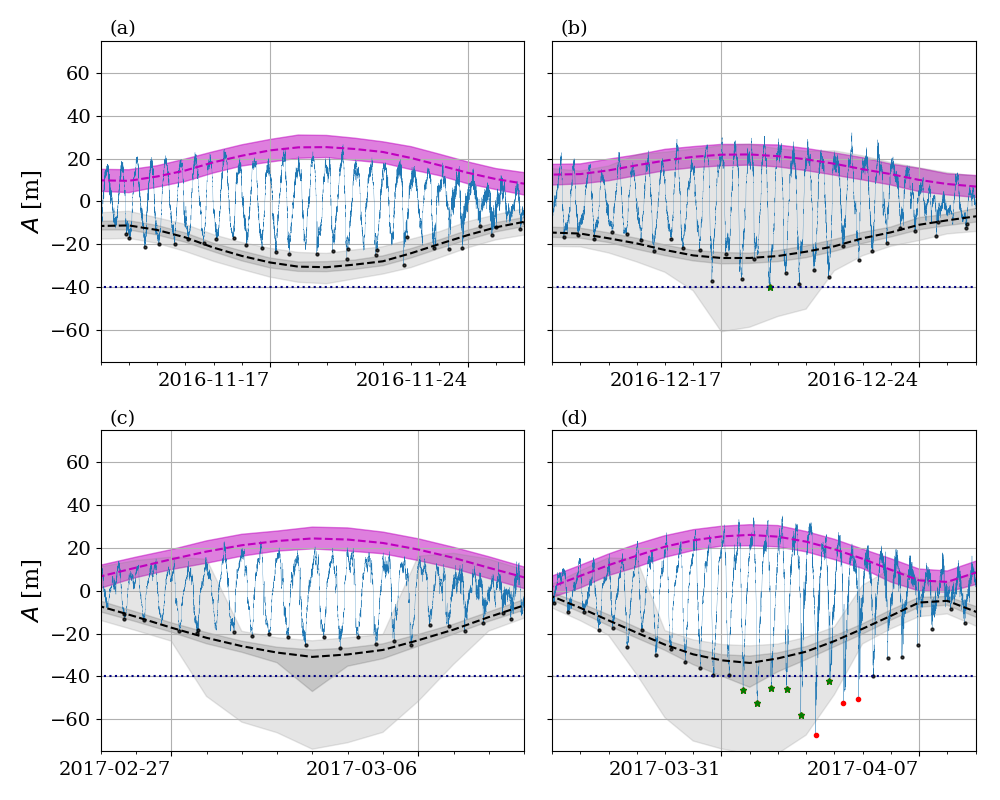

In [60]:


def plot_timeseg(xlim):
    # ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
    A_n.plot(lw=0.2)
    plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

    plt.plot(ta0, a0_samples.mean(axis=1),'m--')
    plt.fill_between(ta0, np.percentile(a0_samples,2.5,axis=1),
             np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

    # ax1.set_xticklabels([])
    # plt.xlabel('')
    # plt.grid(b=True)
    # plt.ylabel('$A$ [m]')
    # plt.ylim(-75,75)
    # plt.title('')
    # plt.xlim(xlim)
    # plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


    # ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
    # plt.fill_between(time, amax_amin, amax_amax, color='0.5',alpha=0.2)
    plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
    plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

    plt.plot(time,amax_50,'k--', lw=1.5)
    #plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
    plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

    plt.plot(ds_A['time'][idx], ds_A.values[idx],'ro', ms=3,)
    plt.plot(ds_A['time'][idx&idx_in], ds_A.values[idx&idx_in],'g*', ms=5, )

    plt.plot([ds_A['time'].values[0],ds_A['time'].values[-1]],[bigwave_thresh,bigwave_thresh],'navy',ls=':')

    # plt.legend(('$A(t)$','$A_{max}$','$a_0(t)$ - median','$A_{max}$ - median','$A_{max}$ - 95%'
    #            ))
    #plt.xlim(200,300)
    plt.ylabel('$A$ [m]')
    plt.ylim(-75,75)
    #plt.xlabel('time [days]')
    plt.grid(b=True)
    #plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
    plt.xlim(xlim)
    #plt.xlabel('time [yyyy-mm]')
    plt.grid(b=True)
    #plt.xlim(time[0],time[-1])
    plt.xticks(rotation=17)
    # plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)
    plt.title('')
    plt.tight_layout()
    plt.show()
    


plt.figure(figsize=(10,8))
ax = plt.subplot(221)
xlim = [datetime(2016,11,11),datetime(2016,11,26)]
plot_timeseg(xlim)
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(a)', transform=ax.transAxes)


ax = plt.subplot(222)
xlim = [datetime(2016,12,11),datetime(2016,12,26)]
plot_timeseg(xlim)
plt.ylabel('')
ax.set_yticklabels([])
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(b)', transform=ax.transAxes)

ax = plt.subplot(223)
xlim = [datetime(2017,2,25),datetime(2017,3,9)]
plot_timeseg(xlim)
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(c)', transform=ax.transAxes)


ax = plt.subplot(224)
xlim = [datetime(2017,3,25),datetime(2017,4,9)]
plot_timeseg(xlim)
plt.ylabel('')
ax.set_yticklabels([])
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(d)', transform=ax.transAxes)

plt.tight_layout()


plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom_eg.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom_eg.pdf'.format(sitename),dpi=150)

In [77]:
# Plot distributions of the input and output

# Locate the time index
t1new = '2016-07-23'
t2new = '2017-04-03'
# ds_A_t1 = dskdv.sel(time=np.datetime64(t1new,'ns').astype(int), method='nearest')
# ds_A_t2 = dskdv.sel(time=np.datetime64(t2new,'ns').astype(int), method='nearest')
ds_A_t1 = dskdv.sel(time=np.datetime64(t1new,'ns'), method='nearest')
ds_A_t2 = dskdv.sel(time=np.datetime64(t2new,'ns'), method='nearest')

#ds_A_t1

<IPython.core.display.Javascript object>


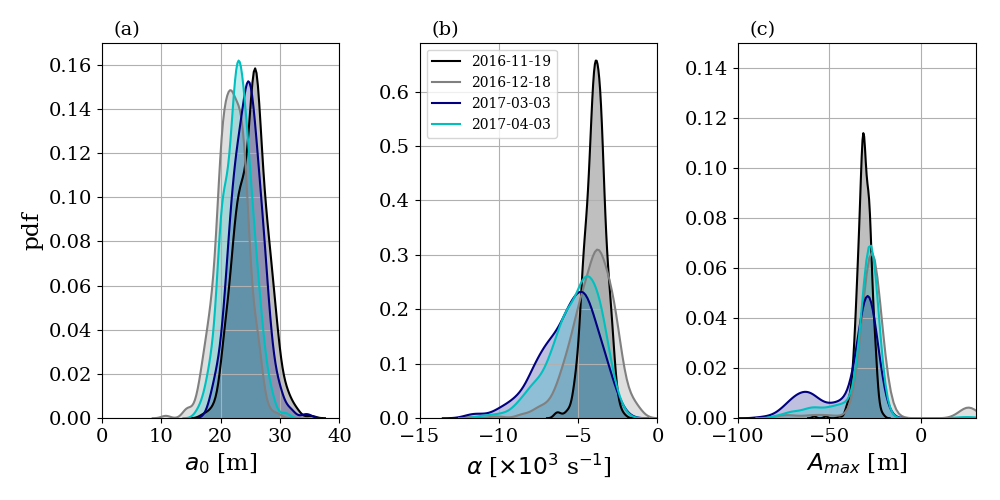

In [91]:
# Locate the time index
t1new = '2016-11-19'
t2new = '2016-12-18'
t3new = '2017-03-03'
t4new = '2017-04-03'



ds_A_t1 = dskdv.sel(time=np.datetime64(t1new,'ns'), method='nearest')
ds_A_t2 = dskdv.sel(time=np.datetime64(t2new,'ns'), method='nearest')
ds_A_t3 = dskdv.sel(time=np.datetime64(t3new,'ns'), method='nearest')
ds_A_t4 = dskdv.sel(time=np.datetime64(t4new,'ns'), method='nearest')


good1 = ~np.isnan(ds_A_t1.amax)


plt.figure(figsize=(10,5))
ax=plt.subplot(131)


sns.kdeplot(ds_A_t1.a0, color='k',shade=True, legend=False)
sns.kdeplot(ds_A_t2.a0, color='0.5',shade=True, legend=False)
sns.kdeplot(ds_A_t3.a0, color='navy',shade=True, legend=False)
sns.kdeplot(ds_A_t4.a0, color='c',shade=True, legend=False)

# sns.kdeplot(ds_A_t1.alpha*1e3, color='k',shade=True, legend=False)
# sns.kdeplot(ds_A_t2.alpha*1e3, color='0.5',shade=True, legend=False)

plt.xlabel('$a_0$ [m]')

plt.ylabel('pdf')
#plt.legend(('mean %s'%t1new,'mean %s'%t2new,t1new,t2new))
# plt.legend((t1new,t2new))
plt.xlim(0,40)

plt.grid(b=True)
ax.text(0.05,1.02, '(a)', transform=ax.transAxes)


# ax=plt.subplot(222)

# # sns.kdeplot(ds_A_t1.cn, color='k',shade=True, legend=False)
# # sns.kdeplot(ds_A_t2.cn, color='0.5',shade=True, legend=False)

# sns.kdeplot(ds_A_t1.cn_mu, color='k',shade=True, legend=False, ls='-')
# sns.kdeplot(ds_A_t2.cn_mu, color='0.5',shade=True, legend=False, ls='-')
# sns.kdeplot(ds_A_t3.cn_mu, color='navy',shade=True, legend=False, ls='-')

# plt.xlabel('$c$ [m s$^{-1}$]')
# plt.grid(b=True)
# ax.text(0.05,1.02, '(b)', transform=ax.transAxes)


ax=plt.subplot(132)
#plt.ylabel('pdf')

sns.kdeplot(ds_A_t1.alpha_mu*1e3, color='k',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t2.alpha_mu*1e3, color='0.5',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t3.alpha_mu*1e3, color='navy',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t4.alpha_mu*1e3, color='c',shade=True, legend=False, ls='-')

plt.xlabel(r'$\alpha$ [$\times 10^3$ s$^{-1}$]')

plt.grid(b=True)
ax.text(0.05,1.02, '(b)', transform=ax.transAxes)
# ax.set_ylim(0,0.20)
plt.xlim(-15,0)
plt.legend((t1new,t2new,t3new, t4new), fontsize=10)

ax=plt.subplot(133)

sns.kdeplot(ds_A_t1.amax, color='k',shade=True, legend=False)
sns.kdeplot(ds_A_t2.amax, color='0.5',shade=True, legend=False)
sns.kdeplot(ds_A_t3.amax, color='navy',shade=True, legend=False)
sns.kdeplot(ds_A_t4.amax, color='c',shade=True, legend=False)

plt.xlim(-100,30)
plt.xlabel('$A_{max}$ [m]')
ax.text(0.05,1.02, '(c)', transform=ax.transAxes)
plt.grid(b=True)
#ax.set_yscale('log')
ax.set_ylim(0,0.15)

plt.tight_layout()

plt.savefig('../FIGURES/vkdv_posteriordist_%s.png'%t1new, dpi=150)
plt.savefig('../FIGURES/vkdv_posteriordist_%s.pdf'%t1new, dpi=300)